In [1]:
import timm
import torch

model = timm.create_model('eva02_large_patch14_448.mim_m38m_ft_in22k_in1k', pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transforms

Compose(
    Resize(size=(448, 448), interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(448, 448))
    MaybeToTensor()
    Normalize(mean=tensor([0.4815, 0.4578, 0.4082]), std=tensor([0.2686, 0.2613, 0.2758]))
)

In [2]:
import numpy as np
from PIL import Image
def transforms_numpy(image: Image.Image):
    image = image.convert('RGB')
    image = image.resize((448, 448), Image.BICUBIC)
    img_numpy = np.array(image).astype(np.float32) / 255.0
    img_numpy = img_numpy.transpose(2, 0, 1)

    mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
    img_numpy = (img_numpy - mean) / std
    img_numpy = np.expand_dims(img_numpy, axis=0)
    img_numpy = img_numpy.astype(np.float32)

    return img_numpy


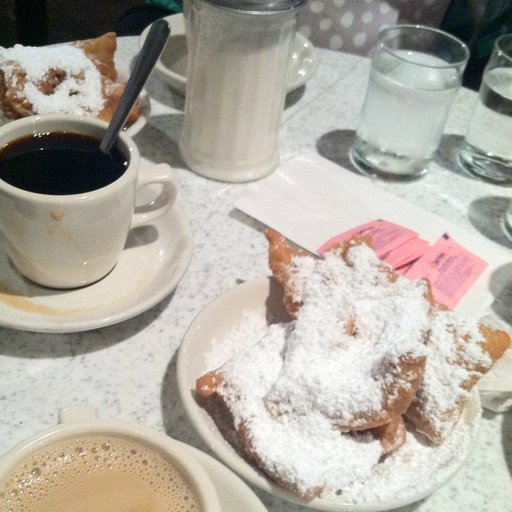

In [3]:
from PIL import Image
from urllib.request import urlopen

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

img

In [4]:
transforms_numpy(img).shape

(1, 3, 448, 448)

In [5]:
## Onnxruntime CPU
import onnxruntime as ort

providers = ['CPUExecutionProvider']
session = ort.InferenceSession('eva02_large_patch14_448.onnx', providers=providers)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

output = session.run([output_name], {input_name: transforms_numpy(img)})
output

[array([[-1.77464217e-01, -1.13817573e-01, -8.76026601e-02,
          8.69853124e-02,  7.27204144e-01, -4.62081969e-01,
         -1.76158428e-01, -3.96329612e-01, -3.04876298e-01,
         -3.45760286e-01, -4.94259745e-01, -1.62426859e-01,
         -1.31224275e-01, -1.17028162e-01,  1.04696602e-02,
         -1.04521327e-01, -2.02701300e-01, -6.22882172e-02,
         -1.12694219e-01, -6.03306115e-01, -4.64288175e-01,
          2.93670595e-02, -1.33947253e-01,  2.18217090e-01,
         -5.31307459e-01,  4.84423935e-02, -3.59963179e-02,
         -5.88736832e-01,  3.68650526e-01, -4.85611260e-01,
         -2.56656110e-01, -4.01910871e-01,  5.98749518e-03,
         -9.85038280e-02, -8.46037418e-02, -2.06972569e-01,
         -2.61949062e-01, -3.54980081e-02,  1.25174671e-01,
         -1.63902849e-01,  2.21279696e-01, -1.22567803e-01,
         -5.68985939e-04, -1.88159660e-01,  3.55500519e-01,
         -1.33886173e-01,  3.23494673e-01, -1.90455168e-02,
         -6.46073669e-02, -3.13407779e-0

In [6]:
output[0].shape

(1, 1000)

In [7]:
import torch
output = torch.from_numpy(output[0])
print(output.shape)

torch.Size([1, 1000])


In [8]:
from imagenet_classes import IMAGENET2012_CLASSES

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

im_classes = list(IMAGENET2012_CLASSES.values())
class_names = [im_classes[i] for i in top5_class_indices[0]]

# Print class names and probabilities
for name, prob in zip(class_names, top5_probabilities[0]):
    print(f"{name}: {prob:.2f}%")

espresso: 28.65%
cup: 2.77%
eggnog: 2.28%
chocolate sauce, chocolate syrup: 2.13%
bakery, bakeshop, bakehouse: 1.42%


In [9]:
import time

num_images = 10
start = time.perf_counter()
for i in range(num_images):
    output = session.run([output_name], {input_name: transforms_numpy(img)})
end = time.perf_counter()
time_taken = end - start

ms_per_image = time_taken / num_images * 1000
fps = num_images / time_taken

print(f"Onnxruntime CPU: {ms_per_image:.3f} ms per image, FPS: {fps:.2f}")

Onnxruntime CPU: 2035.490 ms per image, FPS: 0.49


In [10]:
# onnxruntime GPU
providers = ['CUDAExecutionProvider']
session = ort.InferenceSession('eva02_large_patch14_448.onnx', providers=providers)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

output = session.run([output_name], {input_name: transforms_numpy(img)})
output

2024-09-10 21:28:15.748799795 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 24 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2024-09-10 21:28:15.761006728 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-09-10 21:28:15.761022269 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


[array([[-1.77218258e-01, -1.13883384e-01, -8.80562812e-02,
          8.70764628e-02,  7.27153182e-01, -4.61619258e-01,
         -1.75933331e-01, -3.96952659e-01, -3.04837257e-01,
         -3.45861256e-01, -4.93751228e-01, -1.62900448e-01,
         -1.31234273e-01, -1.17162608e-01,  1.02946777e-02,
         -1.04767464e-01, -2.02962592e-01, -6.23517036e-02,
         -1.12705134e-01, -6.03531361e-01, -4.63928312e-01,
          2.95927841e-02, -1.33596748e-01,  2.19215617e-01,
         -5.31386912e-01,  4.89845388e-02, -3.56880017e-02,
         -5.88470042e-01,  3.69453579e-01, -4.85702395e-01,
         -2.56379753e-01, -4.02000606e-01,  5.94988232e-03,
         -9.83519629e-02, -8.48854631e-02, -2.06789002e-01,
         -2.61435091e-01, -3.61204855e-02,  1.25037342e-01,
         -1.63544223e-01,  2.20759004e-01, -1.22339182e-01,
         -5.24916104e-04, -1.88178897e-01,  3.55434090e-01,
         -1.34087816e-01,  3.23884666e-01, -1.91513784e-02,
         -6.40859753e-02, -3.13261330e-0

In [11]:
import torch
output = torch.from_numpy(output[0])
print(output.shape)

torch.Size([1, 1000])


In [12]:
from imagenet_classes import IMAGENET2012_CLASSES

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

im_classes = list(IMAGENET2012_CLASSES.values())
class_names = [im_classes[i] for i in top5_class_indices[0]]

# Print class names and probabilities
for name, prob in zip(class_names, top5_probabilities[0]):
    print(f"{name}: {prob:.2f}%")

espresso: 28.61%
cup: 2.77%
eggnog: 2.28%
chocolate sauce, chocolate syrup: 2.13%
bakery, bakeshop, bakehouse: 1.42%


In [13]:
import time

num_images = 10
start = time.perf_counter()
for i in range(num_images):
    output = session.run([output_name], {input_name: transforms_numpy(img)})
end = time.perf_counter()
time_taken = end - start

ms_per_image = time_taken / num_images * 1000
fps = num_images / time_taken

print(f"Onnxruntime CUDA: {ms_per_image:.3f} ms per image, FPS: {fps:.2f}")

Onnxruntime CUDA: 61.169 ms per image, FPS: 16.35
